## Experiments with of a diffused censored GP in BayesNewton - Fake data 1

### Required imports

In [30]:
import bayesnewton
import numpy as np
import matplotlib.pyplot as plt
import time
import objax
import jax.numpy as jnp
import math
from tqdm import tqdm
from sklearn.metrics import r2_score
from censored_diffused_GP import *
plt.rcParams.update({'font.size': 16})
import seaborn as sns

LOG2PI = math.log(2 * math.pi)
INV2PI = (2 * math.pi) ** -1

### GP hyper-params

In [31]:
var_f = 1.0         # GP variance
len_f = 10.0         # GP lengthscale
lik_variance = 0.1  # Variance of the likelihood

### Create dataset

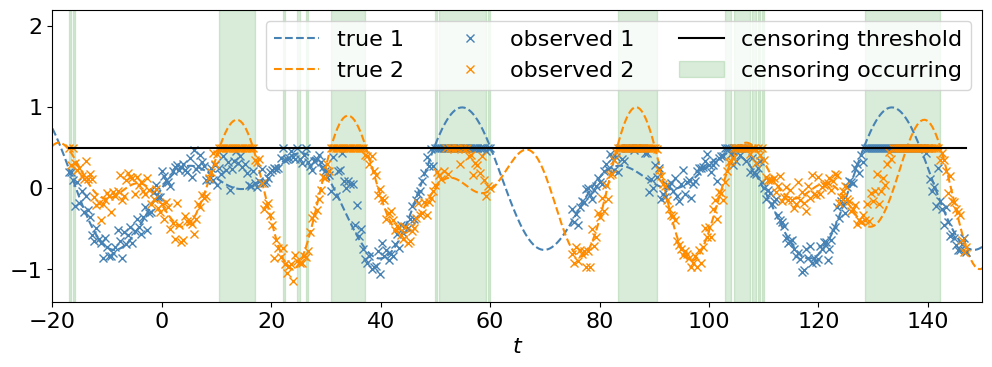

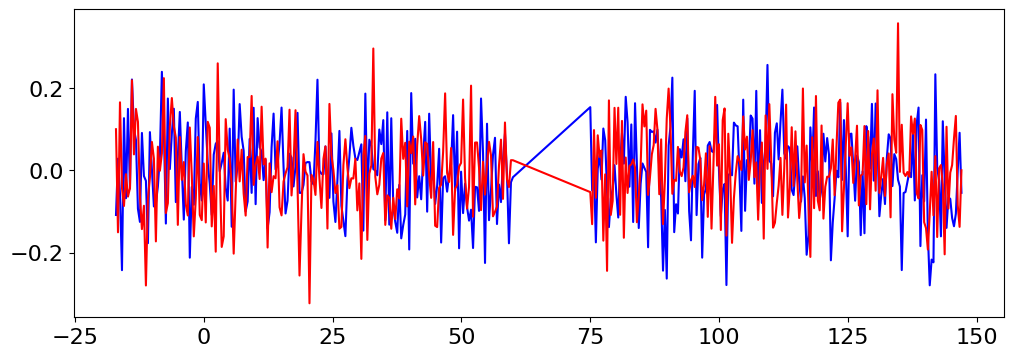

In [32]:
def wiggly_time_series_1(x_):
    return np.cos(0.04*x_+0.33*np.pi) * np.sin(0.2*x_)


def wiggly_time_series_2(x_):
    x_ = x_.copy() - 50
    return np.cos(0.05*x_+0.4*np.pi) * np.sin(0.3*x_)
    #return 2 * wiggly_time_series_1(x_)
    #return wiggly_time_series_1(x_)


np.random.seed(123)
N = 200
# x = np.linspace(-17, 147, num=N)
x = np.concatenate([
    np.linspace(-17, 60, num=N),
    np.linspace(75, 147, num=N)
    ], axis=0)
f1 = wiggly_time_series_1(x)[:, None]
f2 = wiggly_time_series_2(x)[:, None]
f = np.concatenate([f1, f2], axis=1)[..., None]

#noise_cov = np.array([[0.2, 0.1], [0.1, 0.3]])
#noise_cov = np.array([[0.1, 0.05], [0.05, 0.2]])
noise_cov = np.array([[0.01, 0.0], [0.00, 0.01]])

noise = np.linalg.cholesky(noise_cov)[None] @ np.random.multivariate_normal(np.zeros(2), np.eye(2), f.shape[0])[..., None]
y = f + noise

censoring_thre = 0.5*np.ones(y.shape)
censoring_indicator = y > censoring_thre
y_cens = np.where(censoring_indicator, censoring_thre, y)
y_excess = y - y_cens
y_diffused = y_cens.copy()
y_diffused[:, 0] += y_excess[:, 1]
y_diffused[:, 1] += y_excess[:, 0]

# throw away excess demand even after diffusion
y_diffused = np.minimum(y_diffused, censoring_thre)

#x_test = np.linspace(np.min(x)-0.0, np.max(x)+0.0, num=500)
x_test = np.concatenate([
    np.linspace(-17, 60, num=500),
    np.linspace(75, 147, num=500)
    ], axis=0)
f1_test = wiggly_time_series_1(x_test)[:, None]
f2_test = wiggly_time_series_2(x_test)[:, None]
f_test = np.concatenate([f1_test, f2_test], axis=1)[..., None]
noise_test = np.linalg.cholesky(noise_cov)[None] @ np.random.multivariate_normal(np.zeros(2), np.eye(2), f_test.shape[0])[..., None]
y_test = f_test + noise_test
x_plot = np.linspace(np.min(x)-3.0, np.max(x)+3.0, 500)
f1_plot = wiggly_time_series_1(x_plot)
f2_plot = wiggly_time_series_2(x_plot)



in_censoring = False
censoring_start = x[0]
censoring_ranges = []
for i in range(len(censoring_indicator)):
    if in_censoring:
        if not np.any(censoring_indicator[i]):
            censoring_ranges.append([censoring_start, x[i]])
            in_censoring = False
    else:
        if np.any(censoring_indicator[i]):
            censoring_start = x[i]
            in_censoring = True

plt.figure(1, figsize=(12, 4))
plt.plot(x_plot, f1_plot, '--', color='steelblue', label='true 1')
plt.plot(x_plot, f2_plot, '--', color='darkorange', label='true 2')
plt.plot(x, y_diffused[:, 0], 'x', color='steelblue', label='observed 1')
plt.plot(x, y_diffused[:, 1], 'x', color='darkorange', label='observed 2')
plt.plot(x, censoring_thre[:,0], 'k-', label='censoring threshold')
first = True
for pair in censoring_ranges:
    if first:
        plt.axvspan(pair[0], pair[1], alpha=0.15, color='green', label='censoring occurring')
        first = False
    else:
        plt.axvspan(pair[0], pair[1], alpha=0.15, color='green')
plt.legend(loc="upper right", ncol=3)
plt.ylim([-1.4, 2.2])
plt.xlim([x_plot[0], x_plot[-1]])
plt.xlabel('$t$')
#plt.ylabel('demand')
plt.subplots_adjust(bottom=0.15)
plt.savefig('fake_data.pdf', format='pdf')
plt.show()

plt.figure(2, figsize=(12, 4))
plt.plot(x, noise[:, 0], 'b')
plt.plot(x, noise[:, 1], 'r')
plt.show()

In [4]:
X_diffusion = jnp.array([[-1,-1],
                         [1,1]])

print("----------------------- Regularized Laplacian kernel:")
print(k_RL(X_diffusion, lengthscale=10, beta=1))

print("----------------------- Diffusion kernel:")
print(k_Diff(X_diffusion, lengthscale=10, beta=1))

print("----------------------- My diffusion kernel:")
print(compute_transition_matrix(X_diffusion, diffusion_lengthscale=10))

----------------------- Regularized Laplacian kernel:
W: [[1.         0.92311635]
 [0.92311635 1.        ]]
Lap: [[ 0.92311635 -0.92311635]
 [-0.92311635  0.92311635]]
[[0.67567081 0.32432919]
 [0.32432919 0.67567081]]
----------------------- Diffusion kernel:
W: [[1.         0.92311635]
 [0.92311635 1.        ]]
Lap: [[ 0.92311635 -0.92311635]
 [-0.92311635  0.92311635]]
[[0.39727905 2.51712241]
 [2.51712241 0.39727905]]
----------------------- My diffusion kernel:
[[0. 1.]
 [1. 0.]]


censoring_threshold: (400, 2) 
 [[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
f_pred: (400, 2) 
 [[ 0.13089053  0.57344817]
 [ 0.19600409  0.28641588]
 [ 0.03791101  0.56113525]
 [-0.21852843  0.30865137]
 [ 0.07988984  0.21804079]]
excess_demand: (400, 2) 
 [[0.         0.07344817]
 [0.         0.        ]
 [0.         0.06113525]
 [0.         0.        ]
 [0.         0.        ]]
diffused_f: (400, 2) 
 [[ 0.20433869  0.57344817]
 [ 0.19600409  0.28641588]
 [ 0.09904626  0.56113525]
 [-0.21852843  0.30865137]
 [ 0.07988984  0.21804079]]


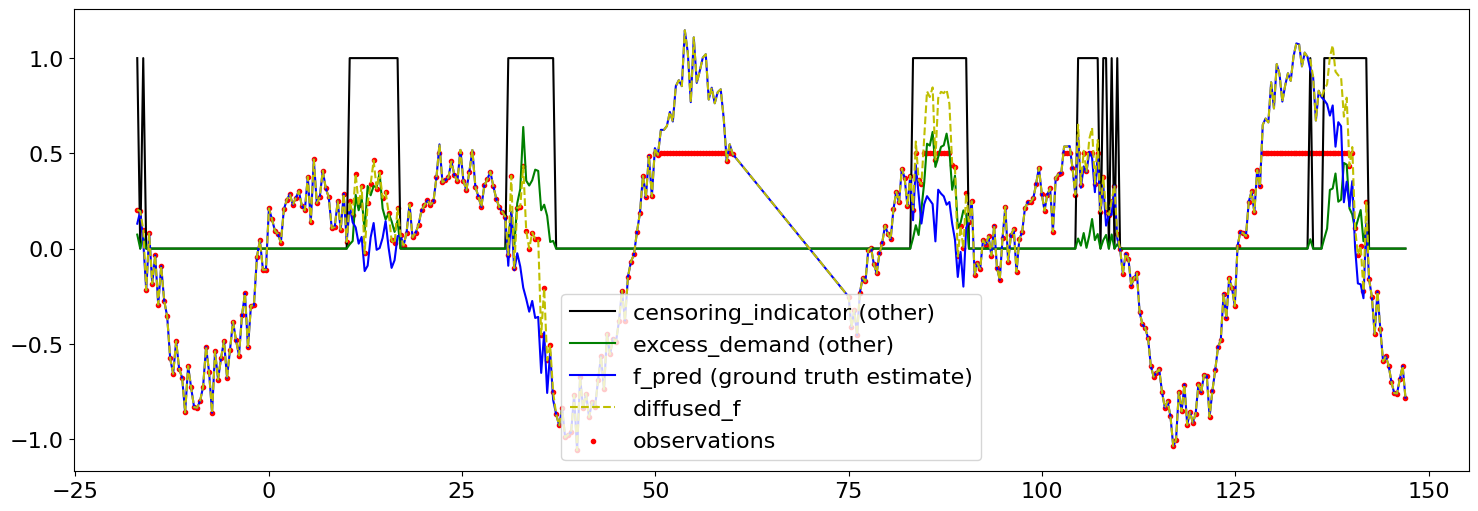

In [5]:
### Testing out the diffusion process to see if it is working

transition_matrix = compute_transition_matrix(X_diffusion, diffusion_lengthscale=10)

### Diffuse excess demand based on transition matrix define above for k diffusion steps
censoring_threshold = censoring_thre[:,:,0]
print("censoring_threshold:", censoring_threshold.shape, '\n', censoring_threshold[:5])
f_pred = y[:,:,0] ## assume perfect estimate for f_pred
print("f_pred:", f_pred.shape, '\n', f_pred[:5])
excess_demand = jnp.maximum(f_pred - censoring_threshold, jnp.zeros(f_pred.shape))
print("excess_demand:", excess_demand.shape, '\n', excess_demand[:5])
diffused_f = f_pred + excess_demand @ transition_matrix
print("diffused_f:", diffused_f.shape, '\n', diffused_f[:5])
plt.figure(figsize=(18,6))
plt.plot(x, censoring_indicator[:,1], 'k-')
plt.plot(x, excess_demand[:,1], 'g-')
plt.plot(x, f_pred[:,0], 'b-')
plt.plot(x, diffused_f[:,0], 'y--')
plt.scatter(x, y_diffused[:,0,0], marker='.', c='r')
plt.legend(["censoring_indicator (other)", 
            "excess_demand (other)", 
            "f_pred (ground truth estimate)", 
            "diffused_f",
            "observations"])
plt.show()

### Re-usable code blocks for training and evaluating models

In [6]:
def train_model(kern, lik, x, y, iters=500, lr_adam=0.1, lr_newton=0.1):
    # model = bayesnewton.models.MarkovNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovExpectationPropagationGP(kernel=kern, likelihood=lik, X=x, Y=y, power=0.5)
    # -- Gauss-Newton ---
    # model = bayesnewton.models.MarkovGaussNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovVariationalGaussNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # -- quasi-Newton ---
    # model = bayesnewton.models.MarkovQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovVariationalQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovExpectationPropagationQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y, power=0.5)
    # --- Riemannian grads ---
    # model = bayesnewton.models.MarkovVariationalRiemannGP(kernel=kern, likelihood=lik, X=x, Y=y)

    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E


    train_op = objax.Jit(train_op)

    t0 = time.time()
    loop = tqdm(range(iters))
    losses = []
    for i in loop:
        loss = train_op()
        #if not i % 20:
        #    print('iter %2d, energy: %1.4f' % (i, loss[0]))
        loop.set_description(f"Iter [{i}/{iters}]")
        loop.set_postfix(loss=loss[0])
        losses.append(loss[0])
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    
    plt.figure(1, figsize=(6, 4))
    plt.plot(losses, label='training loss')
    plt.title("Training loss")
    plt.show()
    
    return model
    

def eval_model(model, x, y, y_diffused, x_test, y_test, output_file=None):
    t0 = time.time()
    # evaluate on train set 
    posterior_mean_train, posterior_cov_train = model.predict_y(X=x)
    nlpd_train_diff = model.negative_log_predictive_density(X=x, extra=None, Y=y_diffused)
    nlpd_train = model.negative_log_predictive_density(X=x, extra=None, Y=y)
    rmse_train = np.sqrt(np.mean((y[:,:posterior_mean_train.shape[1],0] - posterior_mean_train)**2))
    r2_train = r2_score(y[:,:posterior_mean_train.shape[1],0], np.array(posterior_mean_train)) 
    rmse_f = np.sqrt(np.mean((f[:,:posterior_mean_train.shape[1],0] - posterior_mean_train)**2))
    print('[trainset] nlpd (diff): %2.3f\tnlpd (true): %2.3f\trmse (true): %2.3f\tr2 (true): %2.3f\trmse (func): %2.3f' % (nlpd_train_diff, nlpd_train, rmse_train, r2_train, rmse_f))
    
    # evaluate on test set 
    posterior_mean_test, posterior_cov_test = model.predict_y(X=x_test)
    nlpd_test = model.negative_log_predictive_density(X=x_test, Y=y_test)
    rmse_test = np.sqrt(np.mean((y_test[:,:posterior_mean_test.shape[1],0] - posterior_mean_test)**2))
    r2_test = r2_score(y_test[:,:posterior_mean_test.shape[1],0], np.array(posterior_mean_test))
    rmse_fplot = np.sqrt(np.mean((f_test[:,:posterior_mean_test.shape[1],0] - posterior_mean_test)**2))
    print('[testset] \t\t\tnlpd (true): %2.3f\trmse (true): %2.3f\tr2 (true): %2.3f\trmse (func): %2.3f' % (nlpd_test, rmse_test, r2_test, rmse_fplot))
    t1 = time.time()
    print('prediction time: %2.2f secs' % (t1-t0))

    # make plots with predictions
    posterior_mean, posterior_cov = model.predict_y(X=x_plot)
    posterior_var = bayesnewton.utils.diag(posterior_cov)
    lb = posterior_mean - 1.96 * posterior_var ** 0.5
    ub = posterior_mean + 1.96 * posterior_var ** 0.5

    print('plotting ...')
    plt.figure(1, figsize=(12, 4))
    plt.clf()
    plt.plot(x, y_diffused[:, 0], 'x', color='steelblue', label='observed 1')
    plt.plot(x, y_diffused[:, 1], 'x', color='darkorange', label='observed 2')
    for pair in censoring_ranges:
        plt.axvspan(pair[0], pair[1], alpha=0.15, color='green')
    # plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
    plt.plot(x_plot, posterior_mean[:, 0], color='steelblue', label='inferred 1')
    plt.plot(x_plot, posterior_mean[:, 1], color='darkorange', label='inferred 2')
    plt.plot(x_plot, f1_plot, '--', color='steelblue', label='true 1')
    plt.plot(x_plot, f2_plot, '--', color='darkorange', label='true 2')
    plt.fill_between(x_plot, lb[:, 0], ub[:, 0], color='steelblue', alpha=0.05)
    plt.fill_between(x_plot, lb[:, 1], ub[:, 1], color='darkorange', alpha=0.05)
    plt.xlim([x_plot[0], x_plot[-1]])
    if hasattr(model, 'Z'):
        plt.plot(model.Z.value[:, 0], -2 * np.ones_like(model.Z.value[:, 0]), 'b^', markersize=5)
    #plt.legend()
    plt.legend(loc="upper right", ncol=3)
    plt.ylim([-1.4, 2.2])
    plt.xlabel('$t$')
    #plt.ylabel('demand')
    plt.subplots_adjust(bottom=0.15)
    if output_file is not None:
        plt.savefig(output_file, format='pdf')
    plt.show()

### Fit Gaussian GP to true data

Iter [499/500]: 100%|██████████| 500/500 [00:06<00:00, 75.63it/s, loss=-520.9418396877084] 


optimisation time: 6.63 secs


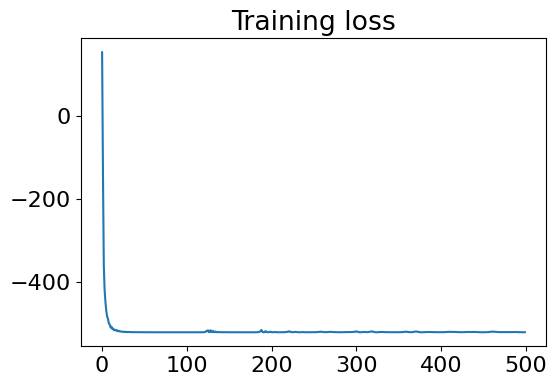

In [7]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyGaussianMulti(ndim=2, variance=lik_variance*jnp.ones(2))
#lik = bayesnewton.likelihoods.Gaussian(variance=1)

model = train_model(kern, lik, x, y)

[trainset] nlpd (diff): 0.350	nlpd (true): -1.854	rmse (true): 0.095	r2 (true): 0.964	rmse (func): 0.029
[testset] 			nlpd (true): -1.774	rmse (true): 0.099	r2 (true): 0.960	rmse (func): 0.029
prediction time: 4.60 secs
plotting ...


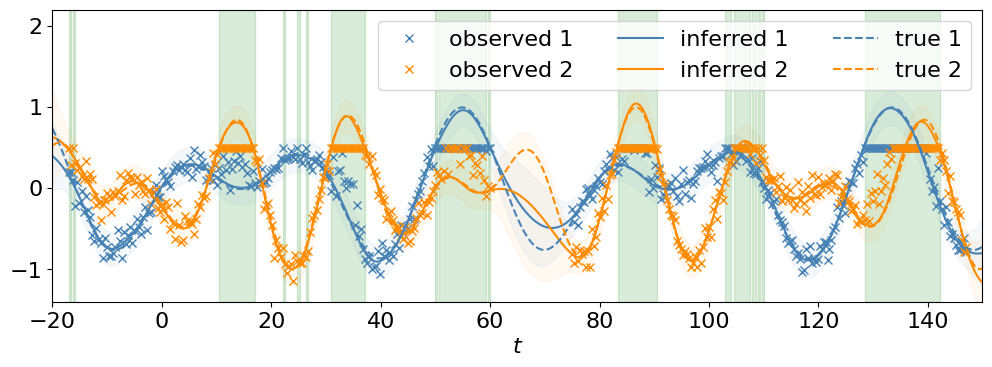

In [8]:
eval_model(model, x, y, y_diffused, x_test, y_test, output_file='fake_fit_true.pdf')

### Fit Gaussian GP to diffused data

Iter [499/500]: 100%|██████████| 500/500 [00:06<00:00, 77.84it/s, loss=-539.5238059030771] 


optimisation time: 6.42 secs


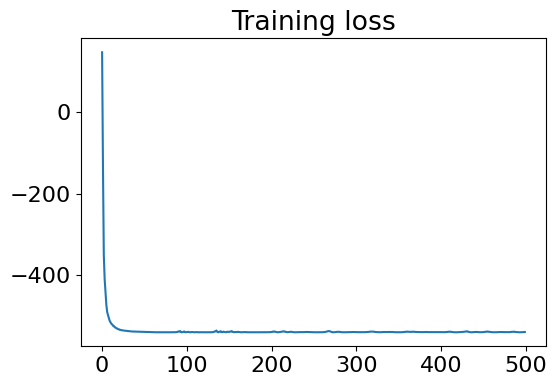

In [9]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyGaussianMulti(ndim=2, variance=lik_variance*jnp.ones(2))
#lik = bayesnewton.likelihoods.Gaussian(variance=1)

model = train_model(kern, lik, x, y_diffused)

[trainset] nlpd (diff): -1.981	nlpd (true): 0.634	rmse (true): 0.183	r2 (true): 0.867	rmse (func): 0.163
[testset] 			nlpd (true): 0.853	rmse (true): 0.188	r2 (true): 0.858	rmse (func): 0.163
prediction time: 1.93 secs
plotting ...


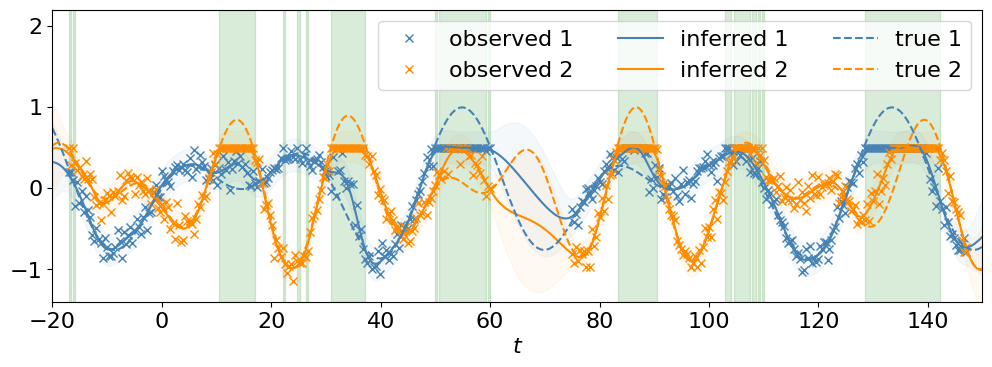

In [10]:
eval_model(model, x, y, y_diffused, x_test, y_test, output_file='fake_fit_gp.pdf')

### Fit Censored Gaussian GP to diffused data

Iter [499/500]: 100%|██████████| 500/500 [00:11<00:00, 42.63it/s, loss=-280.9987288296051] 


optimisation time: 11.73 secs


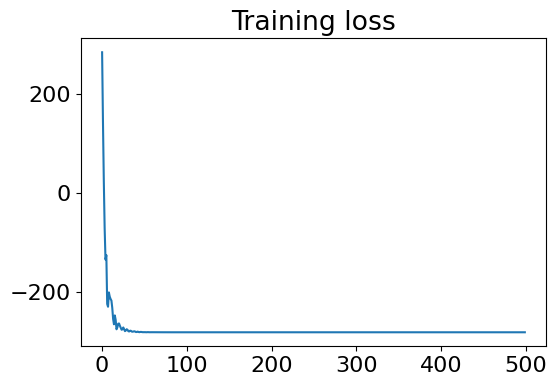

In [11]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyCensoredGaussianMulti(ndim=2, variance=lik_variance*jnp.ones(2))
#lik = bayesnewton.likelihoods.Gaussian(variance=1)

model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1))

[trainset] nlpd (diff): -1.238	nlpd (true): -0.795	rmse (true): 0.155	r2 (true): 0.904	rmse (func): 0.130
[testset] 			nlpd (true): -0.674	rmse (true): 0.162	r2 (true): 0.895	rmse (func): 0.130
prediction time: 2.66 secs
plotting ...


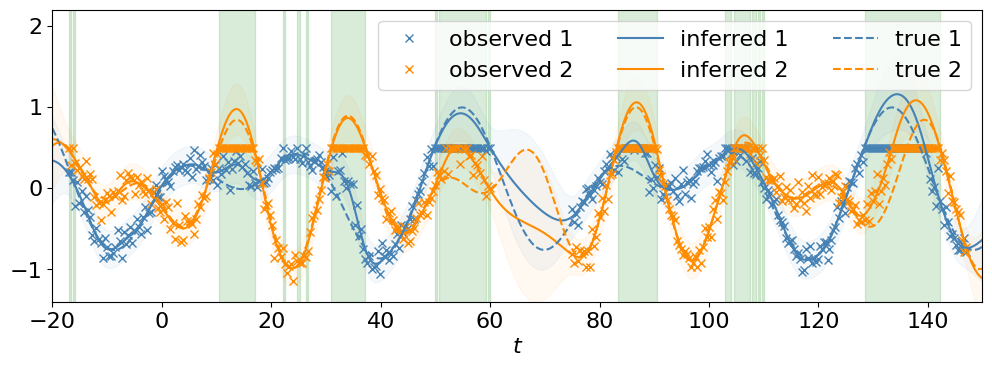

In [12]:
eval_model(model, 
           x, np.concatenate([y, censoring_thre], axis=1), np.concatenate([y_diffused, censoring_thre], axis=1), 
           x_test, np.concatenate([y_test, censoring_thre[0,0]*jnp.ones(y_test.shape)], axis=1), output_file='fake_fit_censored_gp.pdf')

### Fit Diffused Censored Gaussian GP to diffused data - D

Iter [499/500]: 100%|██████████| 500/500 [00:16<00:00, 30.86it/s, loss=-285.49102587016364]


optimisation time: 16.21 secs


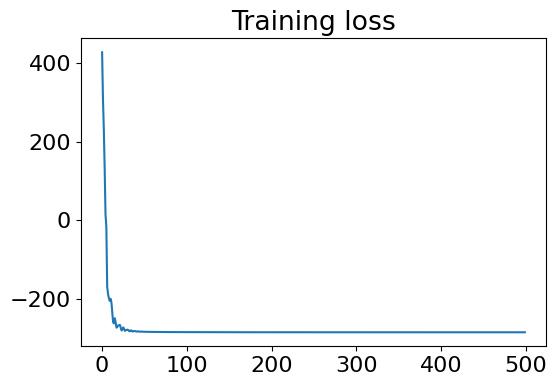

In [22]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
#lik = bayesnewton.likelihoods.Gaussian(variance=1)
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyDiffusedCensoredGaussianMultiD(X_diffusion, 
                                      ndim=2, 
                                      variance=lik_variance*jnp.ones(2),
                                      diffusion_lengthscale=1.,
                                      diffusion_variance=1.,
                                      fix_diffusion=True,
                                      fix_variance=False)

model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1))

[trainset] nlpd (diff): -1.236	nlpd (true): -0.816	rmse (true): 0.103	r2 (true): 0.958	rmse (func): 0.051
[testset] 			nlpd (true): -0.685	rmse (true): 0.108	r2 (true): 0.953	rmse (func): 0.051
prediction time: 2.28 secs
plotting ...


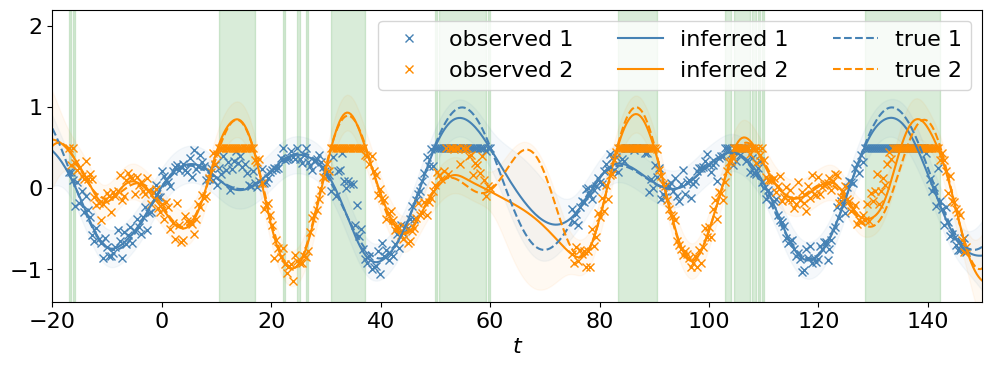

In [23]:
eval_model(model, 
           x, np.concatenate([y, censoring_thre], axis=1), np.concatenate([y_diffused, censoring_thre], axis=1), 
           x_test, np.concatenate([y_test, censoring_thre[0,0]*jnp.ones(y_test.shape)], axis=1))

Iter [499/500]: 100%|██████████| 500/500 [00:22<00:00, 22.65it/s, loss=-289.05575002595225]


optimisation time: 22.08 secs


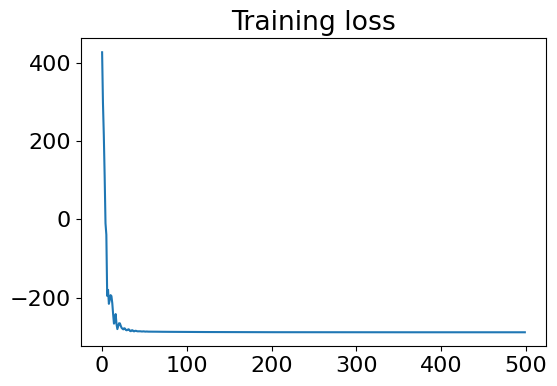

In [25]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2])
#lik = bayesnewton.likelihoods.Gaussian(variance=1)
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyDiffusedCensoredGaussianMultiD(X_diffusion, 
                                      ndim=2, 
                                      variance=lik_variance*jnp.ones(2),
                                      diffusion_lengthscale=1.,
                                      diffusion_variance=1.,
                                      fix_diffusion=False,
                                      fix_variance=False)

model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1))

[trainset] nlpd (diff): -1.239	nlpd (true): -0.859	rmse (true): 0.112	r2 (true): 0.950	rmse (func): 0.070
[testset] 			nlpd (true): -0.751	rmse (true): 0.118	r2 (true): 0.944	rmse (func): 0.071
prediction time: 2.47 secs
plotting ...


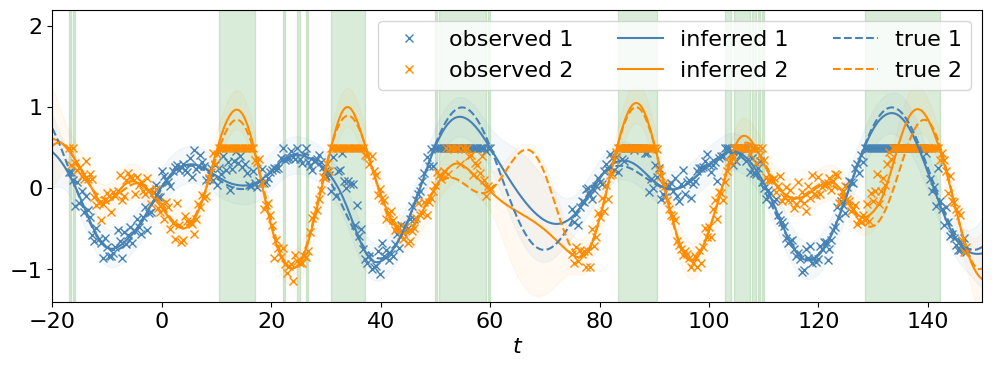

In [26]:
eval_model(model, 
           x, np.concatenate([y, censoring_thre], axis=1), np.concatenate([y_diffused, censoring_thre], axis=1), 
           x_test, np.concatenate([y_test, censoring_thre[0,0]*jnp.ones(y_test.shape)], axis=1), output_file='fake_fit_diffused_censored_gp.pdf')